# HOMER DATA PROCESSING SCRIPT
The goal of this script is to take the output file of HOMER Pro Batch Runs (.xlsx file containing one optimal case/sheet) and produce a condensed data set + plots.

General flow:
1) Run HOMER study via batch process. Select "export results" and name the file.


2) Import file to this script.


3) Use Pandas to pull .xlsx data into a more usable format. 


4) Use collected data to build plots. 

Goals:


Have this script take a large HOMER study (>100 cases) and build one easily accessible database.


Potentially couple this script with a HOMER input reading script to do cartography w/HOMER geography + results.


In [3]:
# Block of dependencies and working directory
import matplotlib.pyplot as plt
import conda
import numpy  as np 
import pandas as pd
import os 
import shutil
from cycler import cycler
directory = 'd:/repo/homer/ClimateStudies/OutputProcessing/Data' #home PC
#directory = 'c:/repo/homer/ClimateStudies/OutputProcessing/Data' #laptop

## Following this guide for xlsx reading
https://stackoverflow.com/questions/26521266/using-pandas-to-pd-read-excel-for-multiple-worksheets-of-the-same-workbook

In [4]:
# reads, maps all sheets 
files = os.listdir(directory)
output_df = {} #creates empty dictionary
names = [] #creates empty list for future name storage
for file in files:
    if file.endswith('.xlsx'):
        xls = pd.ExcelFile(directory + '/' + file) #reads file
        names = names + xls.sheet_names
        for sheet_name in xls.sheet_names: #pulls individual sheets
            output_df[sheet_name] = xls.parse(sheet_name) #puts each sheet into a dictionary w/key "sheet_name"
display(output_df[sheet_name])

,Architecture/PV\n(kW),Architecture/G1500,Architecture/GenLarge\n(kW),Architecture/1kWh LI,Cost/NPC\n($),Cost/COE\n($),Cost/Operating cost\n($/yr),Cost/Initial capital\n($),System/Ren Frac\n(%),System/Total Fuel\n(L/yr),...,GenLarge/Fuel Cost\n($/yr),PV/Capital Cost\n($),PV/Production\n(kWh/yr),G1500/Capital Cost\n($),G1500/Production\n(kWh/yr),G1500/O&M Cost\n($),1kWh LI/Autonomy\n(hr),1kWh LI/Annual Throughput\n(kWh/yr),1kWh LI/Nominal Capacity\n(kWh),1kWh LI/Usable Nominal Capacity\n(kWh)
0,74305.687555,13,NaN,77203,268865728,0.220980,4799146.50,102043144,100.000000,0,...,NaN,55729264.0,117888568,19987500,33314920.0,497250,15.440631,10027248.0,77203.156250,61762.523438
1,74469.297134,13,NaN,77165,269061952,0.221138,4801634.00,102152896,100.000000,0,...,NaN,55851972.0,118148136,19987500,33314920.0,497250,15.433031,10026532.0,77165.156250,61732.125000
2,74416.394418,14,NaN,74254,269883712,0.221812,4810742.00,102658064,100.000000,0,...,NaN,55812296.0,118064208,21525000,35877608.0,535500,14.850830,9799102.0,74254.148438,59403.320312
3,78536.714041,12,NaN,76795,270071744,0.221960,4790786.00,103539784,100.000000,0,...,NaN,58902536.0,124601232,18450000,30752234.0,459000,15.359031,10252882.0,76795.156250,61436.121094
4,80596.659039,12,NaN,74576,270331520,0.222182,4775581.50,104328064,100.000000,0,...,NaN,60447496.0,127869408,18450000,30752234.0,459000,14.915230,10237940.0,74576.148438,59660.917969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,17769.626864,7,4000.0,23816,313712672,0.257721,2919993.00,212211136,72.025818,2527368,...,0.0,13327220.0,28192132,10762500,17938804.0,267750,4.763209,6214931.0,23816.046875,19052.837891
1996,11438.409326,5,4000.0,36686,313713984,0.257658,3018841.50,208776384,69.634583,2744088,...,0.0,8578807.0,18147436,7687500,12813431.0,191250,7.337214,8329274.5,36686.074219,29348.859375
1997,15420.093331,7,4000.0,32524,313719904,0.257646,2885469.75,213418416,76.179726,2152752,...,0.0,11565070.0,24464516,10762500,17938804.0,267750,6.504813,7835992.0,32524.064453,26019.251953
1998,11869.627970,7,4000.0,36720,313722048,0.257635,2920974.50,212186400,75.016251,2258016,...,0.0,8902221.0,18831578,10762500,17938804.0,267750,7.344015,8185626.0,36720.074219,29376.058594


In [5]:
#pulling interesting data points from each 
opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)','GenMin'])
new_cases = pd.DataFrame(columns=['FileName','CaseNum','Case1 LCOE','Case5 LCOE','Architecture/GenLarge\n(kW)'])
tencases = ['Case10','Case11', 'Case12', 'Case13','Case14','Case15','Case16']
n = len(names)
display(n)
for i in range(n):
    name = names[i] # Grabs Sheet Name
    KCC = name[-3:]     #grabs KCC from last 3 values
    if KCC[-2:].casefold() == ('Af'.casefold()):
            KCC = 'Af'
            Location = name[5:-2]
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            elif name[:6] == 'Case10':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            else:
                Location = name[5:-2]
                case_num = name[:5]
    elif KCC[-2:].casefold() == 'Am'.casefold():
            KCC = 'Am'
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            elif name[:6] == 'Case10':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            else:
                Location = name[5:-2]
                case_num = name[:5]
    else: 
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-3]
                case_num = name[:6] # Grabs Case Number 
            #elif name[:6] == 'Case10' or name[:6]=='Case':
            elif name[:6] in tencases:
                Location = name[6:-3]
                case_num = name[:6] # Grabs Case Number 
            else:
                Location = name[5:-3]
                case_num = name[:5]
    KCC = KCC.lower()
    filtered_out = output_df[name].filter(['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)']) #Filtering objects of interest
    filtered_out['CaseName'] = Location #adding actual case name to series
    filtered_out['CaseNum'] = case_num # adding case num to series
    filtered_out['KCC'] = KCC
    framed = filtered_out.iloc[[0]] #making the actual df
    framed.set_index(['CaseNum','CaseName'], inplace=True, drop=True) #building df w/ casename and num
    opt_out = pd.concat([framed,opt_out]) #concating all DFs together
  

    
# Data Cleanup    
opt_out = opt_out[ ['KCC'] + [ col for col in opt_out.columns if col != 'KCC' ] ] #sorting df to have KCC first
opt_out = opt_out.sort_index()
opt_out.to_excel("LocationalVarianceTrimmed.xlsx")


display(opt_out)
#display(new_cases)  

639

KCC  Architecture/PV\n(kW)  Architecture/G1500  \
CaseNum CaseName                                                     
Case1   Anchorage   dfc           67432.441304                28.0   
        Ashland     dfb           39799.095877                19.0   
        AtlantaGA   cfa           92802.980815                 3.0   
        BangorME    dfb           62211.324125                20.0   
        BendOre     bsk           40050.377085                23.0   
...                 ...                    ...                 ...   
Case8   RaleighNC   cfa           32126.631249                 7.0   
        ReddingCA   csa           26843.735929                 4.0   
        RichmondVA  cfa           37944.276532                 5.0   
        Sacramento  csa           19589.237011                 2.0   
        Syracuse    dfb           74305.687555                13.0   

                   Architecture/GenLarge\n(kW) Architecture/1kWh LI  \
CaseNum CaseName                                                      
Case1   Anchorage                          NaN               238148   
        Ashland                            NaN                83635   
        AtlantaGA                          NaN               121958   
        BangorME                           NaN               143357   
        BendOre                            NaN                93120   
...                                        ...                  ...   
Case8   RaleighNC                       3000.0                40384   
        ReddingCA                         3000                38229   
        RichmondVA                        3000                46024   
        Sacramento                      3000.0                32783   
        Syracuse                           NaN                77203   

                    Cost/COE\n($) GenMin  
CaseNum CaseName                          
Case1   Anchorage        0.437239    NaN  
        Ashland          0.207991    NaN  
        AtlantaGA        0.252627    NaN  
        BangorME         0.301640    NaN  
        BendOre          0.233319    NaN  
...                           ...    ...  
Case8   RaleighNC        0.236074    NaN  
        ReddingCA        0.233377    NaN  
        RichmondVA       0.244868    NaN  
        Sacramento       0.216778    NaN  
        Syracuse         0.220980    NaN  

[639 rows x 7 columns]

In [6]:
#for index = opt_out.ind
#display(pd.MultiIndex.get_level_values(opt_out('CaseNum')))
Case1 = opt_out.loc[("Case1",slice(None))]
Case1CFA = Case1.query("KCC=='cfa'")
Case2 = opt_out.loc[("Case2",slice(None))]
Case2CFA = Case2.query("KCC=='cfa'")
Case25 = opt_out.loc[("Case25",slice(None))]
Case3 = opt_out.loc[("Case3",slice(None))]
Case3CFA = Case3.query("KCC=='cfa'")
Case35 = opt_out.loc[("Case35",slice(None))]
Case4 = opt_out.loc[("Case4",slice(None))]
Case4CFA = Case4.query("KCC=='cfa'")
#display(Case4CFA)
# Testing
Case5 = opt_out.loc[("Case5",slice(None))]
Case6 = opt_out.loc[("Case6",slice(None))]
Case7 = opt_out.loc[("Case7",slice(None))]
Case8 = opt_out.loc[("Case8",slice(None))]
Case10 = opt_out.loc[("Case10",slice(None))]
Case11 = opt_out.loc[("Case11",slice(None))]
Case12 = opt_out.loc[("Case12",slice(None))]
Case13 = opt_out.loc[("Case13",slice(None))]
Case14 = opt_out.loc[("Case14",slice(None))]
Case15 = opt_out.loc[("Case15",slice(None))]
Case16 = opt_out.loc[("Case16",slice(None))]
display(Case16)
#Case1.plot(y='Cost/COE\n($)', use_index=True)

,KCC,Architecture/PV\n(kW),Architecture/G1500,Architecture/GenLarge\n(kW),Architecture/1kWh LI,Cost/COE\n($),GenMin
CaseName,,,,,,,
Anchorage,dfc,60605.007467,16.0,2000.0,99118,0.417048,NaN
EielsonAFB,dfc,55498.493447,18.0,1000.0,161100,0.393919,NaN
MedfordOR,csa,116738.950071,4.0,NaN,188467,0.355230,NaN


<Figure size 432x288 with 0 Axes>

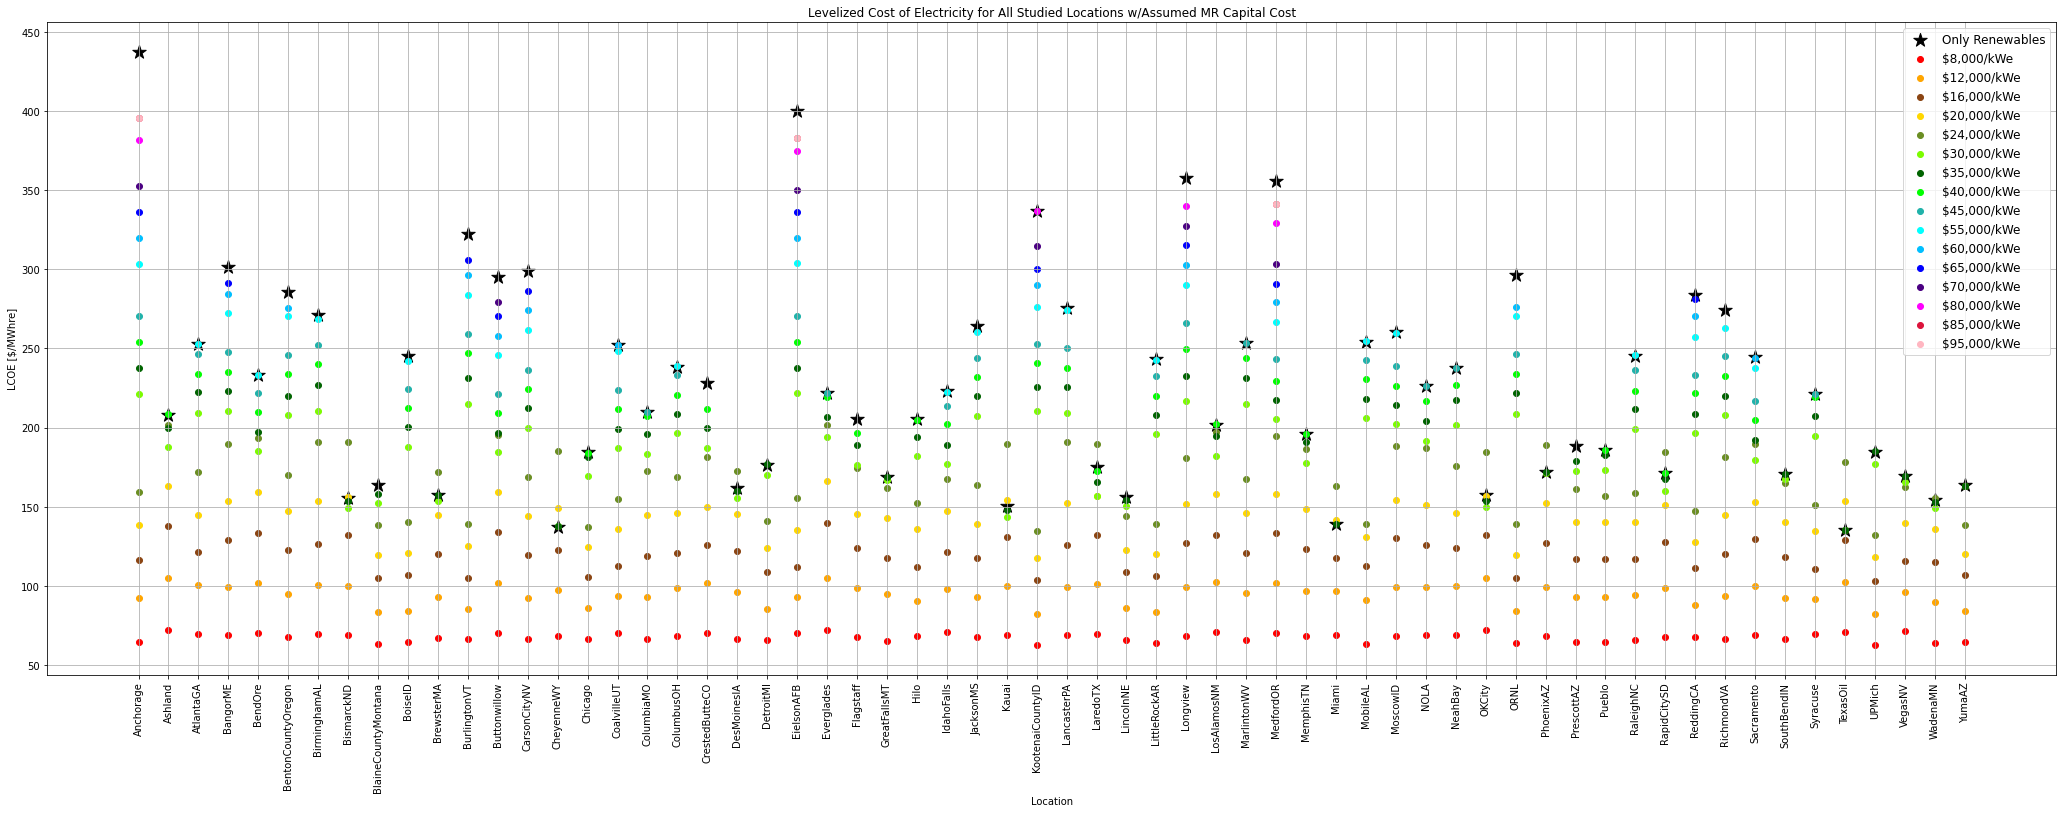

In [7]:
with plt.rc_context():
    plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'orange', 'saddlebrown', 'gold','olivedrab','lawngreen',
                                                    'darkgreen','lime','lightseagreen','cyan','deepskyblue','blue',
                                                    'indigo', 'fuchsia','crimson', 'lightpink'])
    fig = plt.figure()
    fig, ax=plt.subplots(figsize=(36,12))
    ax.scatter( Case1.index.array, Case1['Cost/COE\n($)']*1000,marker='*',s=200)
    ax.scatter( Case1.index.array, Case2['Cost/COE\n($)']*1000)
    ax.scatter( Case1.index.array,Case25['Cost/COE\n($)']*1000)
    ax.scatter( Case1.index.array, Case3['Cost/COE\n($)']*1000)
    ax.scatter( Case1.index.array,Case35['Cost/COE\n($)']*1000)
    ax.scatter( Case1.index.array, Case4['Cost/COE\n($)']*1000)
    ax.scatter( Case5.index.array, Case5['Cost/COE\n($)']*1000)
    ax.scatter( Case6.index.array, Case6['Cost/COE\n($)']*1000)
    ax.scatter( Case7.index.array, Case7['Cost/COE\n($)']*1000)
    ax.scatter( Case8.index.array, Case8['Cost/COE\n($)']*1000)
    ax.scatter(Case10.index.array,Case10['Cost/COE\n($)']*1000)
    ax.scatter(Case11.index.array,Case11['Cost/COE\n($)']*1000)
    ax.scatter(Case12.index.array,Case12['Cost/COE\n($)']*1000)
    ax.scatter(Case13.index.array,Case13['Cost/COE\n($)']*1000)
    ax.scatter(Case14.index.array,Case14['Cost/COE\n($)']*1000)
    ax.scatter(Case15.index.array,Case15['Cost/COE\n($)']*1000)
    ax.scatter(Case15.index.array,Case15['Cost/COE\n($)']*1000)
    ax.legend(['Only Renewables', '$8,000/kWe','$12,000/kWe', 
               '$16,000/kWe', '$20,000/kWe','$24,000/kWe', '$30,000/kWe','$35,000/kWe','$40,000/kWe',
               '$45,000/kWe','$55,000/kWe','$60,000/kWe','$65,000/kWe','$70,000/kWe','$80,000/kWe',
               '$85,000/kWe','$95,000/kWe'], fontsize='large')
    plt.ylabel('LCOE [$/MWhre]')
    plt.xlabel('Location')
    plt.title('Levelized Cost of Electricity for All Studied Locations w/Assumed MR Capital Cost', fontsize='large')
    plt.xticks(rotation=90);
    ax.grid(True)


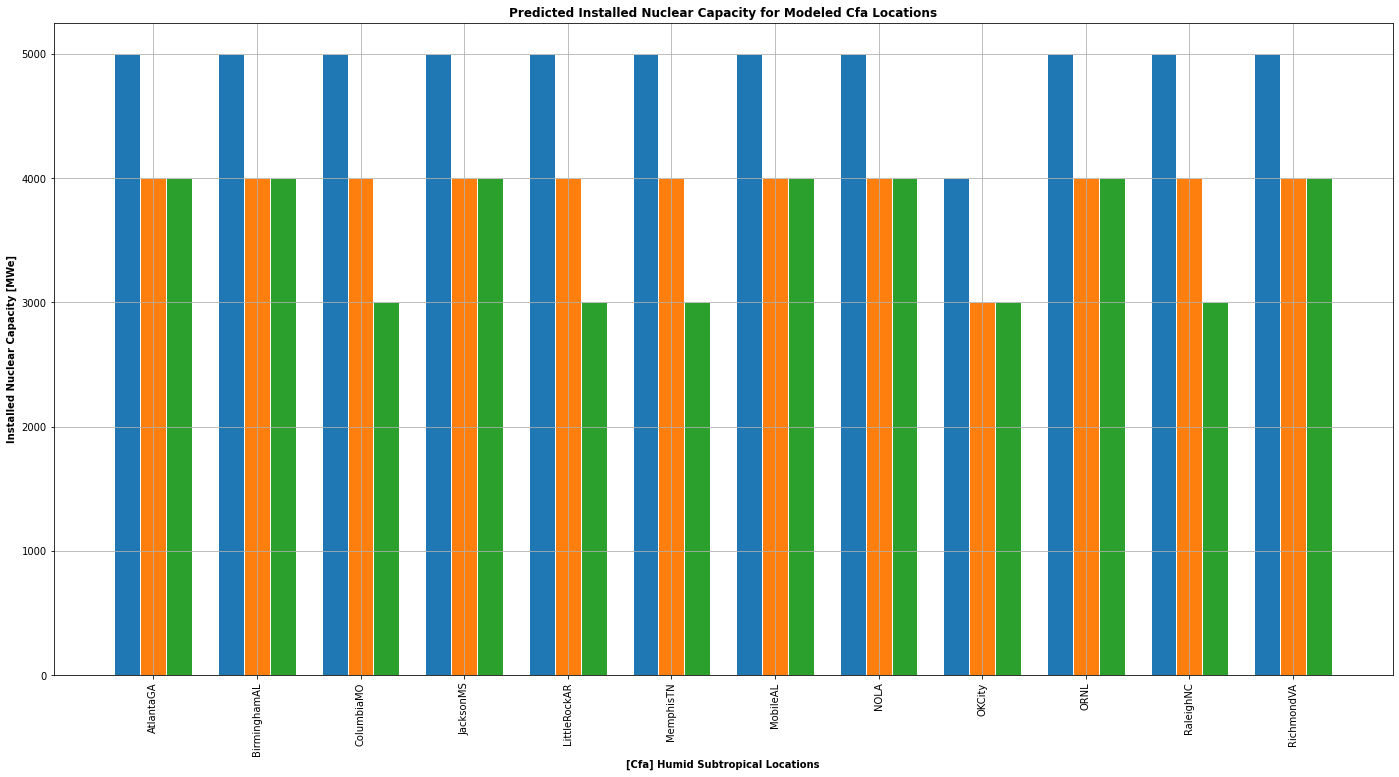

In [8]:
m = len(Case2CFA)
fig = plt.figure(figsize=(24,12))
barWidth = 0.25
# Grabbing Generator Size Data
bars1 = Case2CFA["Architecture/GenLarge\n(kW)"]
#bars15 = Case25CFA["Architecture/GenLarge\n(kW)"]
bars2 = Case3CFA["Architecture/GenLarge\n(kW)"]
#bars25 = Case35CFA["Architecture/GenLarge\n(kW)"]
bars3 = Case4CFA["Architecture/GenLarge\n(kW)"]
#ranges
r1 = np.arange(m)
#r15 = [x+barWidth for x in r1]
r2 = [x+barWidth for x in r1]
#r25 = [x+barWidth for x in r2]
r3 = [x+barWidth for x in r2]

# Plotting
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='LowCostNuclear')
#plt.bar(r15, bars15, width=barWidth, edgecolor='white', label='LoMidCostNuclear')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='MidCostNuclear')
#plt.bar(r25, bars25, width=barWidth, edgecolor='white', label='MidCostNuclear')
plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='HighCostNuclear')
# Add xticks on the middle of the group bars
plt.ylabel('Installed Nuclear Capacity [MWe]',fontweight='bold')
plt.xlabel('[Cfa] Humid Subtropical Locations',fontweight='bold')
plt.title('Predicted Installed Nuclear Capacity for Modeled Cfa Locations',fontweight='bold')
plt.xticks([r + barWidth for r in range(m)], Case2CFA.index.values)
plt.xticks(rotation=90);
plt.grid(True)
 


<Figure size 432x288 with 0 Axes>

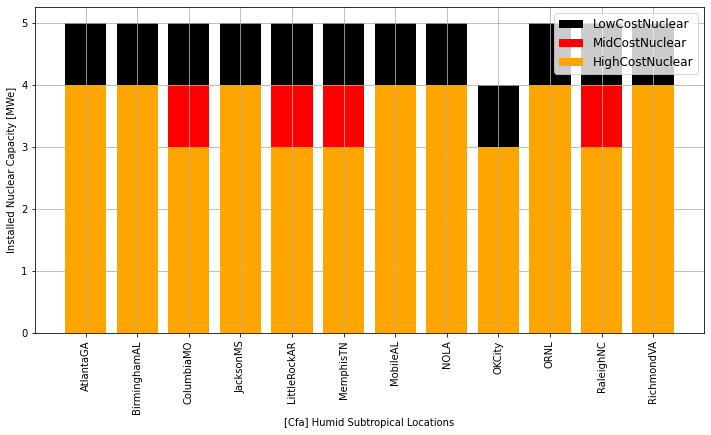

In [9]:
# Initial KCC Plots
with plt.rc_context():
    plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'orange', 'saddlebrown', 'gold','olivedrab','lawngreen',
                                                    'darkgreen','lime','lightseagreen','cyan','deepskyblue','blue',
                                                    'indigo', 'fuchsia','crimson'])
    fig = plt.figure()
    fig, ax=plt.subplots(figsize=(12,6))
    #ax.scatter( Case1CFA.index.array, Case1CFA['Architecture/GenLarge\n(kW)']*1000,marker='*',s=200)
    ax.bar( Case2CFA.index.array, Case2CFA['Architecture/GenLarge\n(kW)']/1000)
    ax.bar( Case3CFA.index.array, Case3CFA['Architecture/GenLarge\n(kW)']/1000)
    ax.bar( Case4CFA.index.array, Case4CFA['Architecture/GenLarge\n(kW)']/1000)
    ax.legend([ 'LowCostNuclear', 'MidCostNuclear', 'HighCostNuclear'], fontsize='large')
    plt.ylabel('Installed Nuclear Capacity [MWe]')
    plt.xlabel('[Cfa] Humid Subtropical Locations')
    plt.xticks(rotation=90);
    #plt.yticks([3,4,5])
    ax.grid(True)